In [221]:
# Import Dependencies
from pathlib import Path
import numpy as np
import pandas as pd
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


In [222]:
# Import file of futures contract on the Yen-dollar exchange rate
# This is the continuous chain of the futures contracts that are 1 month to expiration

yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [223]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1989-01-01":, :]
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0


<AxesSubplot:xlabel='Date'>

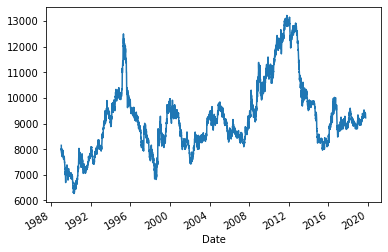

In [224]:
# Plot just the "Settle" column from the dataframe
yen_futures.Settle.plot()

In [225]:
# Observation: The Yen has had major swings from 1990-2019. Over this period Yen has devalued against USD. There are ceertainly events around 1992, 1996, 2000 and 2015 with major spikes. Since 2008-2015, there has been consistent weekening that was reversed in 2016 with Yen strengthening against USD. Since 2016, Yen is again weekening against USD until 2019.

In [226]:
import statsmodels.api as sm

#1. Hodrick-Prescott filter by decomposing the "Settle" price into two separate series

df=yen_futures[["Settle"]].copy()
ts_noise, ts_trend =  sm.tsa.filters.hpfilter(df['Settle'])

In [227]:
ts_trend.head()

Date
1989-01-03    8060.447551
1989-01-04    8043.723181
1989-01-05    8027.054156
1989-01-06    8010.521621
1989-01-09    7994.195433
Name: Settle_trend, dtype: float64

In [228]:
ts_noise.head()

Date
1989-01-03    88.552449
1989-01-04    41.276819
1989-01-05   -18.054156
1989-01-06   -43.521621
1989-01-09    23.804567
Name: Settle_cycle, dtype: float64

In [229]:
yen_futures_decomp = None

# Dataframe of the settle price with Noise and Trend

yen_futures_decomp =  df[['Settle']].copy()
yen_futures_decomp["Noise"] =  ts_noise
yen_futures_decomp["Trend"] =  ts_trend
yen_futures_decomp.head()

,Settle,Noise,Trend
Date,,,
1989-01-03,8149.0,88.552449,8060.447551
1989-01-04,8085.0,41.276819,8043.723181
1989-01-05,8009.0,-18.054156,8027.054156
1989-01-06,7967.0,-43.521621,8010.521621
1989-01-09,8018.0,23.804567,7994.195433


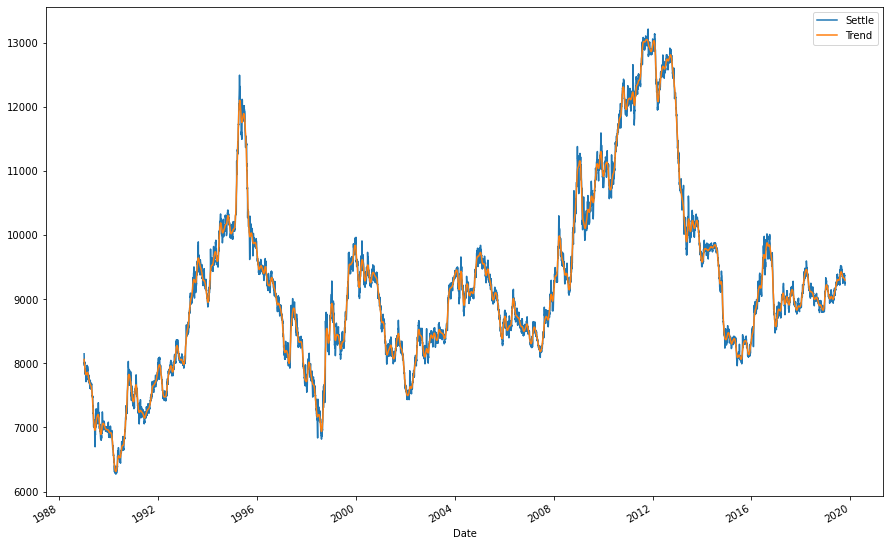

In [230]:
# Plot of "Settle" with "Trend" price 
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)

yen_futures_decomp[["Settle","Trend"]].plot(ax=ax)
plt.show()



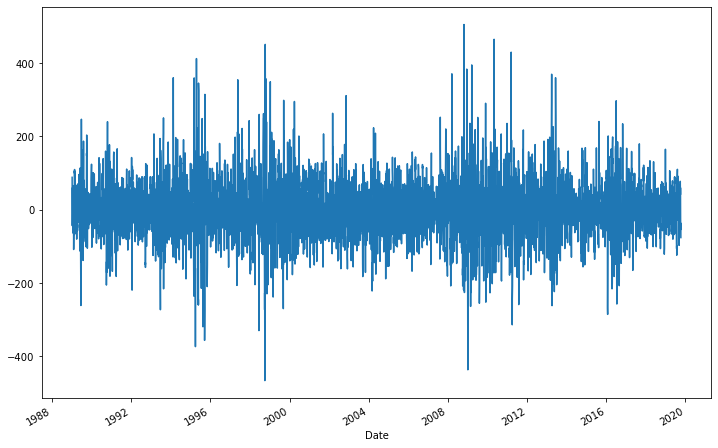

In [231]:
# Plot of "Noise"  

yen_futures_decomp["Noise"].plot(figsize=(12,8))
plt.show()

In [232]:
# Observations: With HP Filter and looking at resulting trends, there are short-term fluctuations. There could be short-term trading opportunities where two color lines in the graph deviates from each oher resulting in Yen undervalued v USD or Yen overvalued against USD resulting in long or short positions respectively.

In [233]:
#2. Using futures Settle *Returns*, estimate an ARMA model

#A. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
#B. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
#C. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)



In [244]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [245]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
from statsmodels.tsa.arima_model import ARMA 

model = ARMA(returns.values, order=(2,1))
model

# Fit the model and assign it to a variable called results
results= model.fit()

C:\Users\munir\anaconda3\envs\alpacaenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [246]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7766
Model:                     ARMA(2, 1)   Log Likelihood               -8170.868
Method:                       css-mle   S.D. of innovations              0.693
Date:                Wed, 24 Feb 2021   AIC                          16351.736
Time:                        16:22:46   BIC                          16386.523
Sample:                             0   HQIC                         16363.661
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.008      0.531      0.596      -0.011       0.019
ar.L1.y        0.7106      0.193      3.686      0.000       0.333       1.089
ar.L2.y       -0.0031      0.012     -0.257      0.797      -0.027       0.021
ma.L1.y       -0.7195      0.192     -3.738      0.000      -1.097      -0.342
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4160           +0.0000j            1.4160            0.0000
AR.2          226.0943           +0.0000j          226.0943            0.0000
MA.1            1.3898           +0.0000j            1.3898            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

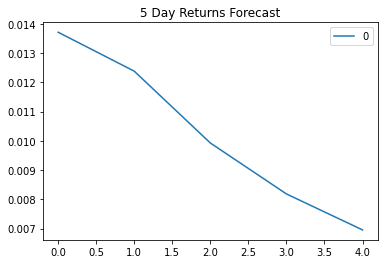

In [248]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

In [249]:
# Observations: As the p-value is greater than  0.05, it is concluded that ARMA model used in Yen-USD forecasting is not a good model.  

In [158]:
#3. Forecasting the Settle Price using an ARIMA Model

In [193]:
# A. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     # a. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     # b. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
# B. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
# C. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [194]:
from statsmodels.tsa.arima_model import ARIMA


In [196]:
#Estimate and ARIMA Model:
model = ARIMA(yen_futures['Settle'], order=(5, 1, 1))

C:\Users\munir\anaconda3\envs\alpacaenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\munir\anaconda3\envs\alpacaenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [197]:
# Fit the model
results = model.fit()

In [198]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7766
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -43308.740
Method:                       css-mle   S.D. of innovations             63.929
Date:                Wed, 24 Feb 2021   AIC                          86633.480
Time:                        15:56:37   BIC                          86689.140
Sample:                             1   HQIC                         86652.559
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1397      0.686      0.204      0.839      -1.205       1.484
ar.L1.D.Settle     0.3349      0.669      0.501      0.616      -0.976       1.646
ar.L2.D.Settle     0.0012      0.015      0.079      0.937      -0.028       0.030
ar.L3.D.Settle    -0.0113      0.012     -0.929      0.353      -0.035       0.013
ar.L4.D.Settle    -0.0148      0.015     -1.013      0.311      -0.043       0.014
ar.L5.D.Settle     0.0006      0.018      0.034      0.973      -0.035       0.036
ma.L1.D.Settle    -0.3481      0.669     -0.521      0.603      -1.659       0.962
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9603           -1.3492j            2.3798           -0.0959
AR.2            1.9603           +1.3492j            2.3798            0.0959
AR.3           -2.3139           -2.5004j            3.4068           -0.3688
AR.4           -2.3139           +2.5004j            3.4068            0.3688
AR.5           24.1860           -0.0000j           24.1860           -0.0000
MA.1            2.8728           +0.0000j            2.8728            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

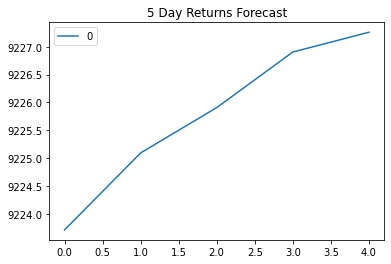

In [199]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

In [ ]:
# Observations: As the p-value is greater than  0.05, it is concluded that ARIMA model used in Yen-USD forecasting is not a good model.  

In [200]:
#4 Volatility Forecasting with GARCH

# Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. 
# Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
# Using futures Settle *Returns*, estimate an GARCH model
# A. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
# B. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
# 3. Plot the 5-day forecast of the volatility.

In [201]:
# Import arch model 
import arch

In [202]:
# Estimate a GARCH model
model = arch_model(returns['Settle'], mean="Zero", vol="GARCH", p=2,q=1)

In [203]:
# Fit the model
arch_results = model.fit(disp="off")

In [204]:
# Summarize ARCH model results
arch_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7729.60
Distribution:                  Normal   AIC:                           15467.2
Method:            Maximum Likelihood   BIC:                           15495.0
                                        No. Observations:                 7766
Date:                Wed, Feb 24 2021   Df Residuals:                     7766
Time:                        15:56:47   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.9328e-03  2.377e-03      2.075  3.795e-02  [2.743e-04,9.591e-03]
alpha[1]       0.0409  1.341e-02      3.047  2.313e-03  [1.457e-02,6.714e-02]
alpha[2]       0.0000  1.810e-02      0.000      1.000 [-3.548e-02,3.548e-02]
beta[1]        0.9496  1.572e-02     60.421      0.000      [  0.919,  0.980]
=============================================================================

Covariance estimator: robust
"""

In [205]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [206]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = arch_results.forecast(start=last_day, horizon=forecast_horizon)
forecasts

In [207]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.467504,7.515045,7.561838,7.607902,7.653255


In [208]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.467504
h.2,7.515045
h.3,7.561838
h.4,7.607902
h.5,7.653255


C:\Users\munir\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'5 Day Forecast of Volatility'}>

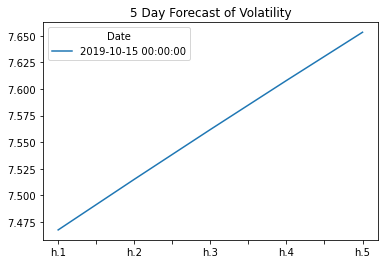

In [209]:
# Plot the final forecast
final.plot(title='5 Day Forecast of Volatility', legend=True)

In [250]:
# Observations: As the p-value is is less than  0.05, it is concluded that GARCH model used in Yen-USD forecasting is a good fit and it can be clncluded that volatility (risk) is expected to increase over next five days forecast period.

In [251]:
# Overal Conclusion: Based on the analysis above, I would not enter into long trade for Yen-USD as there is no conclusive analysis that Yen-USD will strengthen. Moreover, as the volatility is expected to increase over forecasting period, its not recomended for long trade.